In [1]:
#bert中文情感模型预训练过程
import torch#导入 PyTorch，一个流行的深度学习框架，用于构建和训练神经网络。
import re#导入正则化处理模块
from datasets import load_dataset#从 datasets 库中引入 load_dataset 方法，这个库可以方便地加载各种预定义的数据集
from transformers import AdamW#初始化优化器和损失函数
from transformers import BertModel
from transformers import BertTokenizer


In [2]:
# 设置设备，检查是否有 GPU 可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
#device = torch.device("cpu")

#定义数据集
class Dataset(torch.utils.data.Dataset):#定义一个名为 Dataset 的类，继承自 torch.utils.data.Dataset，这是 PyTorch 中的一个基础类，用于创建自定义数据集。
    def __init__(self, split):#初始化函数，在创建类的实例时调用。
        #使用 datasets 库的 load_dataset 方法加载名为 ChnSentiCorp 的中文情感分类数据集
        self.dataset = load_dataset('parquet',data_files={split:f'./ChnSentiCorp/{split}.parquet'})
        self.split = split
    def __len__(self):#定义 __len__ 方法，返回数据集的样本数。
        return len(self.dataset[self.split])
    def __getitem__(self, i):#定义 __getitem__ 方法，用于通过索引 i 获取单个样本。
        text = self.dataset[self.split][i]['text']
        label = self.dataset[self.split][i]['label']

        return text, label#返回文本和标签，作为数据集的单个样本。


dataset = Dataset('train')#创建 Dataset 类的实例，指定 split='train'，加载训练集数据。
token = BertTokenizer.from_pretrained('./bert-base-chinese')

#定义collate_fn对模型数据进行批处理
def collate_fn(data):
    # 从 data 中提取出每个样本的文本（sents）和标签（labels）
    sents = [i[0] for i in data]
    labels = [i[1] for i in data]

    
    #编码
    #使用 token.batch_encode_plus 来批量编码文本。这个函数来自于 Hugging Face 的 transformers 库。
    data = token.batch_encode_plus(batch_text_or_text_pairs=sents,#batch_text_or_text_pairs=sents：要编码的文本列表。
                                   truncation=True,#如果文本超过 max_length，则截断到指定的最大长度。
                                   padding='max_length',#将文本填充到 max_length 指定的长度。
                                   max_length=500,#指定最大长度为 500。
                                   return_tensors='pt',#返回 PyTorch 张量格式。
                                   return_length=True)#返回每个文本的实际长度。

    

    # 提取输入 id、attention mask 和 token type id
    input_ids = data['input_ids'].to(device)
    attention_mask = data['attention_mask'].to(device)
    token_type_ids = data['token_type_ids'].to(device)
    labels = torch.LongTensor(labels).to(device)



    return input_ids, attention_mask, token_type_ids, labels


#数据加载器
loader = torch.utils.data.DataLoader(dataset=dataset,
                                     batch_size=8,
                                     collate_fn=collate_fn,
                                     shuffle=True,
                                     drop_last=True)

#加载bert预训练模型
pretrained = BertModel.from_pretrained('bert-base-chinese')
pretrained = pretrained.to(device)



#不训练,不需要计算梯度
for param in pretrained.parameters():
    param.requires_grad_(False)



#定义下游任务模型，继承自 PyTorch 的 torch.nn.Module。该模型使用了预训练的 BERT 模型（pretrained），并添加了一个全连接层（fc）作为分类头。
#定义模型类 Model
class Model(torch.nn.Module):#这是一个继承自 torch.nn.Module 的自定义类，用于定义下游任务模型。
    #是 PyTorch 中所有神经网络模型的基类，所有自定义模型都应该继承自它。
    def __init__(self):
        super().__init__()#super().__init__() 调用了父类（torch.nn.Module）的构造函数，确保模型正确初始化。
        self.fc = torch.nn.Linear(768, 2)#定义了一个全连接层 fc，它的输入维度是 768，输出维度是 2。

    
    #2. 定义前向传播（forward）方法
    def forward(self, input_ids, attention_mask, token_type_ids):#这是模型的前向传播方法，用于执行推理或训练过程中的计算。在前向传播中，数据将通过模型进行计算，并返回输出结果。
        with torch.no_grad():
            out = pretrained(input_ids=input_ids,#是输入的文本（经过编码后的 token IDs）。
                       attention_mask=attention_mask,#是用于指示哪些位置为填充的掩码（0 表示填充，1 表示有效 token）
                       token_type_ids=token_type_ids)#是用于区分句子的标识符

        # 提取 [CLS] token 进行分类
        cls_embedding = out.last_hidden_state[:, 0]  # 形状: (batch_size, hidden_size)
        
        # 将输出移动到正确的设备上
        cls_embedding = cls_embedding.to(input_ids.device)  # 确保输出在与输入相同的设备上
        
        out = self.fc(cls_embedding)

        #应用 Softmax 激活函数
        out = out.softmax(dim=1)



        return out

Using device: cuda


F:\Adconna\envs\mypytorch1\lib\site-packages\transformers\modeling_utils.py:399: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_locatio

In [3]:
#基于训练好的模型对桂林各大景区游客的情感分析
# 加载整个模型
model = torch.load('./model/sentiment_model_full.pth')
model = model.to(device)
model.eval()  # 切换到评估模式

C:\Users\11952\AppData\Local\Temp\ipykernel_8120\1632465981.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('./model/sentiment_model_full.pth')


Model(
  (fc): Linear(in_features=768, out_features=2, bias=True)
)

In [4]:
def remove_emojis(text):
    # Emoji 正则表达式
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # 表情符号
        "\U0001F300-\U0001F5FF"  # 符号和图片
        "\U0001F680-\U0001F6FF"  # 运输和地图
        "\U0001F1E0-\U0001F1FF"  # 国旗
        "\U00002700-\U000027BF"  # 杂项符号
        "\U0001F900-\U0001F9FF"  # 补充符号和图片
        "\U00002600-\U000026FF"  # 杂项符号（部分）
        "\U00002B50-\U00002B55"  # 杂项符号（部分）
        "]",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r'', text)

In [5]:
#评论数据提取
def extract_comments(Attractions,attraction):
    # 确保字典中有 attraction 键
    if attraction not in Attractions:
        Attractions[attraction] = []
    #打开评论文件
    with open(f'./comment/{attraction}.txt','r',encoding='utf-8') as file:
        for line in file:
            #确保剔除空白行
            if line.strip():
                #按逗号分割,最多分成三部分
                comment = line.split(',',2)
                #如果至少有两个逗号
                if len(comment)>2:
                    Attractions[attraction].append(remove_emojis(comment[2]))#添加第二个逗号后面的部分
    return Attractions



In [6]:
#数据初始化
Attractions = {}
attractions = ['Basilica_of_the_Sacred_Heart','Big_Buddha_Temple','Canton_Tower','Guangdong_Provincial_Museum','Guangzhou_Chimelong_Happy_World',
            'Guangzhou_Chimelong_Wildlife_World','Guangzhou_Zoo','Haixinsha_Asian_Games_Park','Nanyue_King_Museum','Tianzi_Pier','Up_and_down_nine_roads'
            ,'Xiaogang_Park','Yuexiu Park']
for attraction in attractions:
    Attractions[attraction] = []
    Attractions = extract_comments(Attractions,attraction)
# # 打印前 10 条评论
# if 'Big_Buddha_Temple' in Attractions:
#     for comment in Attractions['Big_Buddha_Temple'][:10]:
#         print(comment)
# else:
#     print("No comments found for Big_Buddha_Temple")

In [16]:
#初始化分词器
tokenizer = BertTokenizer.from_pretrained('./bert-base-chinese')
def preprocess_text(text,max_length=128):
    #对文本进行编码,转换为BERT所需的输入格式
    encoding = tokenizer(text,
                         truncation = True,
                         padding = 'max_length',
                         max_length = max_length,
                         return_tensors = 'pt')
    return encoding
def sentiment_anlysize(Attractions,sentiment,attraction):
    #对大量评论数据进行分开处理每次处理完后释放显存重新运行
    for comment in Attractions[attraction]:
        encoding = preprocess_text(comment)
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        #进行情感预测
        with torch.no_grad():
            outputs = model(input_ids = input_ids,
                            attention_mask = attention_mask,
                            token_type_ids = None)
            
        #获取每一条评论的预测结果,标签1为好评,标签0为差评
        pred = torch.argmax(outputs,dim = 1)

        #存储预测结果
        sentiment[attraction].append(pred.item())

        # 删除中间变量并清理缓存
        del outputs, pred, input_ids, attention_mask
        torch.cuda.empty_cache()

    return sentiment


In [23]:
#进行情感模型分析
sentiment = {}
#景点游客评论判断收集
for attraction in attractions:
    sentiment[attraction] = []
    sentiment = sentiment_anlysize(Attractions,sentiment,attraction)



In [24]:
# 打印前 10 条评论情感状态
if 'Basilica_of_the_Sacred_Heart' in sentiment:
    for comment in sentiment['Basilica_of_the_Sacred_Heart'][:100]:
        print(comment)
else:
    print("No comments found for Big_Buddha_Temple")

1
1
1
1
1
1
1
1
1
1
0
1
0
0
1
1
1
1
1
1
1
1
1
1
1
0
1
0
0
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
0
1
0
1
1
1
1
1
1
0
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
0
1
1
1
1
1
1
1


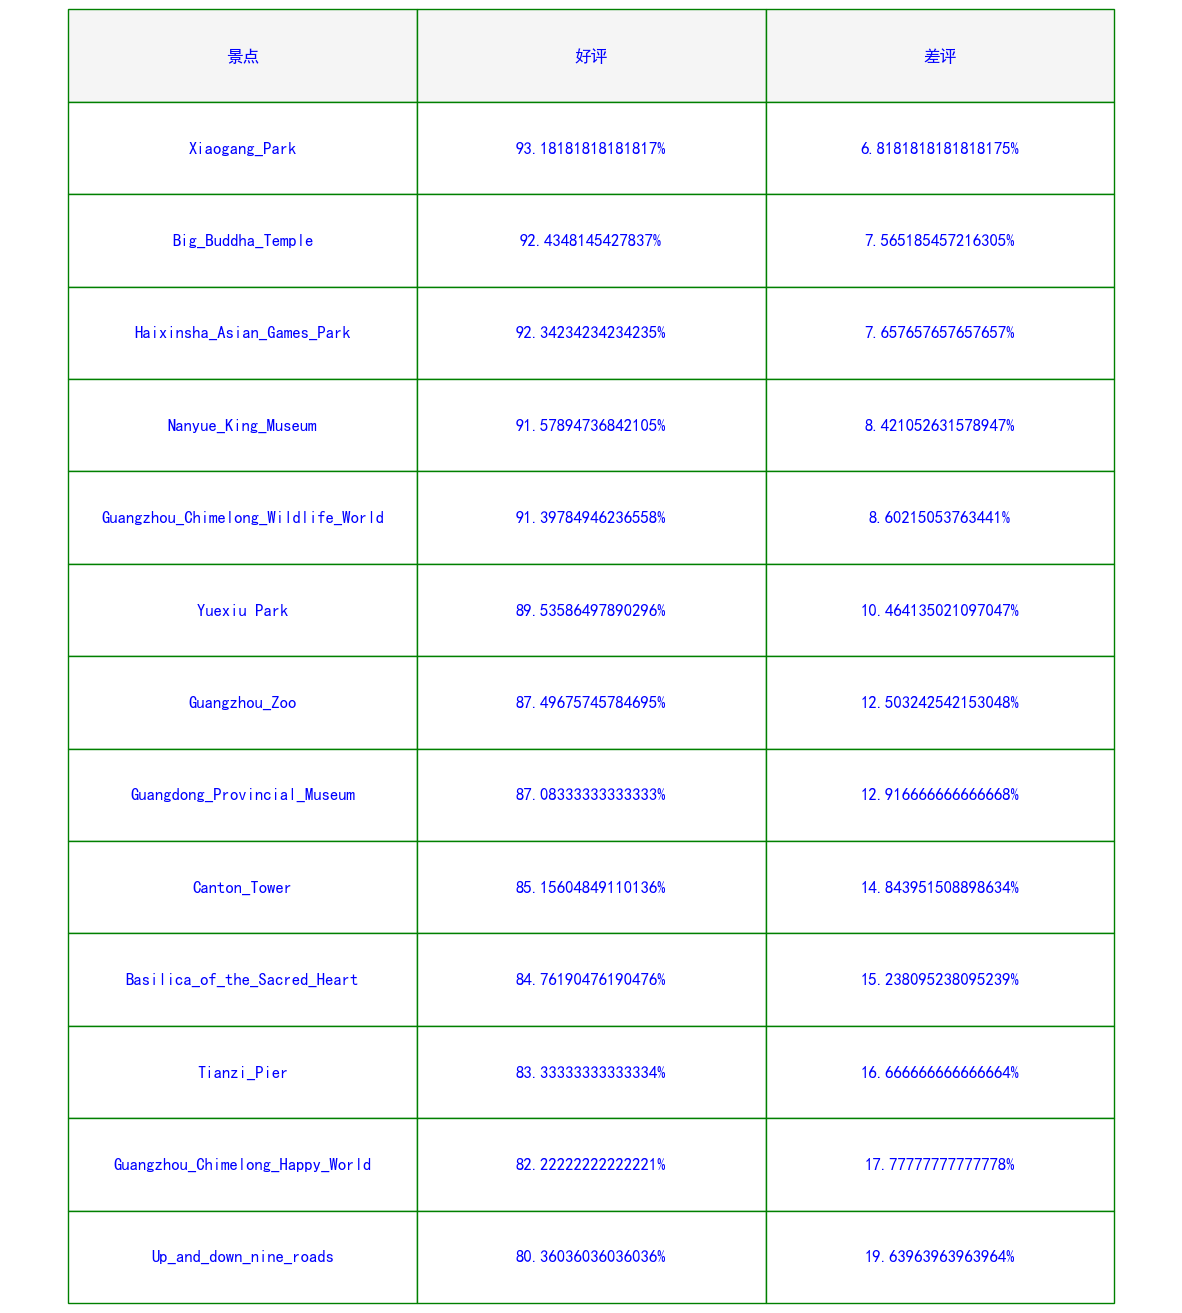

In [79]:
#对情感数据进行图表显示
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib import font_manager


# 设置中文字体
font = font_manager.FontProperties(fname='C:/Windows/Fonts/simhei.ttf')  # 你可以修改为适合自己系统的字体路径
#构造数据,由于每个城市样本数不同故采用百分比形式表示
data = {
    '景点':attractions,
    '好评':[str((values.count(1)/len(values))*100)+'%' for values in sentiment.values()],
    '差评':[str((values.count(0)/len(values))*100)+'%' for values in sentiment.values()]
}

#构造DataFrame
df = pd.DataFrame(data)
#按照好评数排序
df_sorted = df.sort_values(by='好评',ascending=False)

#绘制表格并保持为图片
fig, ax = plt.subplots(figsize=(15,12))

#移除坐标系
ax.axis('off')


#绘制表格
table =ax.table(cellText = df_sorted.values,colLabels = df_sorted.columns,loc='center',cellLoc = 'center',colColours=['#f5f5f5']*3)

# #调整字体大小
# table.auto_set_font_size(False)
# table.set_fontsize(30)

#设置表格单元格的内边距
for key,cell in table.get_celld().items():
    #为每个单元格设置内边距
    cell.set_edgecolor('green') #设置单元格边框颜色
    cell.set_linewidth(1)       #设置边框宽度

    #调整单元格的高度和宽度
    cell.set_height(0.1) #控制单元格的高度
    cell.set_width(0.3)  #控制单元格的宽度
    cell.set_text_props(color = 'blue')
    cell.set_text_props(fontproperties=font)  # 设置字体为支持中文的字体
    cell.set_text_props(fontsize=13)
# 保存为图片
plt.savefig('./attractions_table.png', bbox_inches='tight', dpi=300)

plt.show()

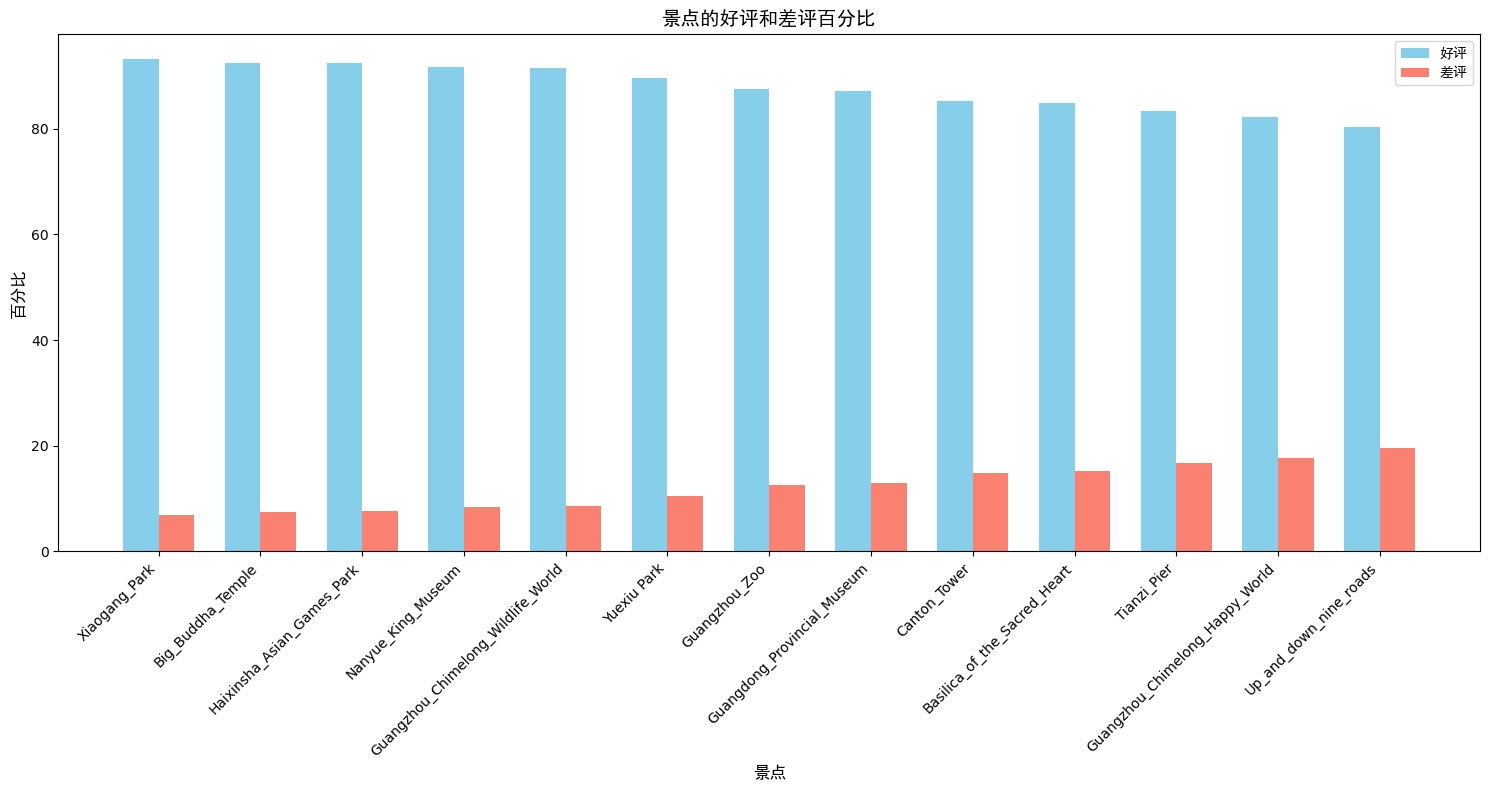

In [96]:
# 设置中文字体
font = font_manager.FontProperties(fname='C:/Windows/Fonts/simhei.ttf')  # 你可以修改为适合自己系统的字体路径

# 确保是字符串类型，先转换为字符串再进行 strip
df_sorted['好评'] = df_sorted['好评'].apply(lambda x: float(str(x).strip('%')))
df_sorted['差评'] = df_sorted['差评'].apply(lambda x: float(str(x).strip('%')))

# 绘制柱状图
fig, ax = plt.subplots(figsize=(15, 8))

# 设置柱子的宽度
width = 0.35

# 绘制两组柱状图
x = range(len(df_sorted))  # X轴的位置

# 绘制好评柱状图
ax.bar(x, df_sorted['好评'], width, label='好评', color='skyblue')

# 绘制差评柱状图
ax.bar([i + width for i in x], df_sorted['差评'], width, label='差评', color='salmon')

# 设置X轴标签
ax.set_xticks([i + width/2 for i in x])  # 将X轴标签位置调整到两柱之间
ax.set_xticklabels(df_sorted['景点'], rotation=45, ha="right")  # 设置景点名称，旋转显示

# 设置图表标题和标签
ax.set_title('景点的好评和差评百分比', fontproperties=font, fontsize=14)
ax.set_xlabel('景点', fontproperties=font, fontsize=12)
ax.set_ylabel('百分比', fontproperties=font, fontsize=12)

# 显示图例
ax.legend(fontsize=14, prop=font)

# 显示图表
plt.tight_layout()  # 自动调整布局以防止标签被截断
plt.show()
